# Processamento de Imagens Digitais 
## Dept. de Estatística, Mat. Aplicada e Computação (DEMAC)
#### Prof. Dr. Daniel Carlos Guimarães Pedronette

# Relatório da lista de exercícios N° 1
-------------------------------
**Nome:** Álvaro Leandro Cavalcante Carneiro 


**Linguagem utilizada:** Python 3.6



## Importando as bibliotecas 
Importando as bibliotecas que serão utilizadas para desenvolver as atividades.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import data

In /home/alvaro/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/alvaro/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/alvaro/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/alvaro/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/alvaro/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

## Carregamento das imagens
As imagens utilizadas serão carregadas da biblioteca *SkImage* [https://scikit-image.org/docs/dev/api/skimage.data.html], assim como as outras listas de exercícios. Assim como os demais exercícios, as imagens RGB serão convertidas para escala de cinza no método *convert_to_gray*.

In [3]:
def convert_to_gray(image, luma=False):
    if luma:
        params = [0.299, 0.589, 0.114]
    else:
        params = [0.2125, 0.7154, 0.0721]

    gray_image = np.ceil(np.dot(image[...,:3], params))
    gray_image[gray_image > 255] = 255
    
    return gray_image

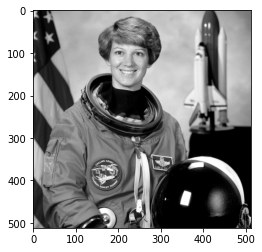

In [4]:
image = convert_to_gray(data.astronaut())
plt.imshow(image, cmap='gray')

## Adicionando ruído às imagens
Será criado o método *add_noise_to_image* que irá adicionar dois tipos de ruídos diferentes às imagens, sendo um deles o ruído sal e pimenta e o outro o ruído gaussiano.

In [5]:
def add_noise_to_image(image):
    # usando numpy para criar uma matriz com média de 50 e desvio padrão de 30 (valor arbitrário)
    gaussian_noise = np.random.normal(loc=50, scale=30, size=image.shape)
    gaussian_img = image + gaussian_noise
    
    row,col = image.shape
    s_vs_p = 0.5
    amount = 0.1
    salt_pepper_img = np.copy(image)

    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
            for i in image.shape]
    salt_pepper_img[tuple(coords)] = 255 # adicionado valor branco em coordenadas aleatórias

    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p)) # número de pontos
    coords = [np.random.randint(0, i - 1, int(num_pepper)) # pegando coordenadas aleatórias
            for i in image.shape]
    salt_pepper_img[tuple(coords)] = 0 # adicionado valor preto em coordenadas aleatórias 

    return gaussian_img, salt_pepper_img

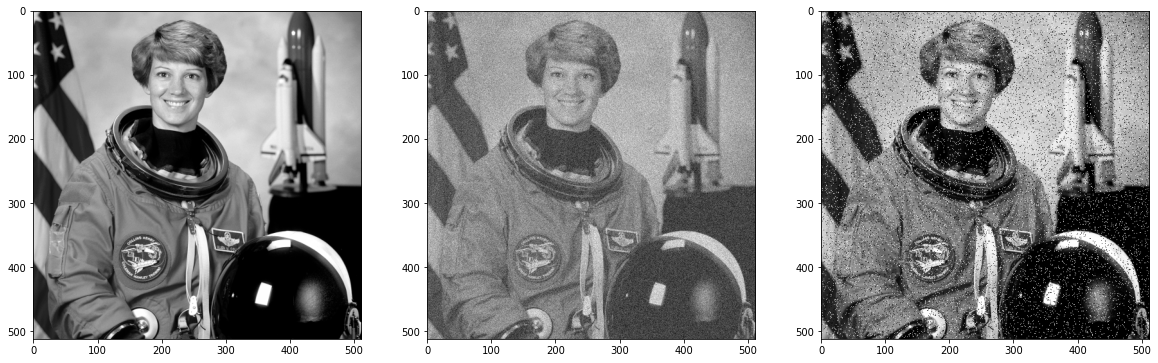

In [6]:
gaussian_img, salt_pepper_img = add_noise_to_image(image)
figure, axarr = plt.subplots(1,3, figsize=(20, 10))
axarr[0].imshow(image, cmap='gray')
axarr[1].imshow(gaussian_img, cmap='gray')
axarr[2].imshow(salt_pepper_img, cmap='gray')

A imagem acima mostra nitidamente o efeito da aplicação dos ruídos à imagem original.

## Filtragem espacial por convolução
A filtragem espacial escolhida foi a convolução e sua implementação foi implementada no método *convolution*. Antes disso, o método *get_img_with_padding* foi criado como estratégia para lidar com os pontos do kernel que caem fora da imagem. Para isso, a imagem foi preenchida com zeros, assim como sugerido no Livro de Gonzalez e Woods (3° edição, P. 96) a fórmula utilizada para preencher as linhas e colunas da imagem com zero foi M - 1 e N - 1 respectivamente, onde M e N são as dimensões do kernel utilizado.

In [7]:
def get_img_with_padding(image, kernel):
    hor_stack = 0
    while ((kernel.shape[0] - 1) - hor_stack) != 0:  # preenche as linhas da matriz
        image = np.insert(image, 0, 0, axis=0)
        image = np.vstack([image, np.zeros(image.shape[1])])
        hor_stack += 1
        
    vert_stack = 0
    while ((kernel.shape[0] - 1) - vert_stack) != 0: # preenche as colunas
        image = np.insert(image, 0, 0, axis=1)
        image = np.hstack([image, np.zeros((image.shape[0], 1))])
        vert_stack += 1
        
    return image

In [8]:
def convolution(image, kernel, stride, function=False, padding=False):
    initial_line = 0
    final_line = kernel.shape[0]
    new_image = []

    if padding:
        image = get_img_with_padding(image, kernel)
    
    while final_line <= image.shape[0]: # percorrendo pelas linhas    
        initial_column = 0
        final_column = kernel.shape[1]
        matrix_line = []

        while final_column <= image.shape[1]: # percorrendo pelas colunas
            # área da imagem que será multiplicada pelo kernel
            kernel_area = image[initial_line:final_line, initial_column:final_column]
            
            # esse IF define se será aplicado uma função personalizada ou uma simples multiplicação matricial
            if function:
                matrix_line.append(function(kernel_area))
            else:
                matrix_line.append(np.sum(kernel * kernel_area))
        
            initial_column += stride # quantidade de linhas a serem puladas 
            final_column += stride
        
        new_image.append(matrix_line) 
        final_line += 1
        initial_line += 1

    return np.asmatrix(new_image)

## Definindo os Kernels
Os kernels foram definidos como arrays multidimensionais do numpy, sendo eles o filtro da média, mediana e o gaussiano. A média possui os valores de 0.11 para cada posição do kernel, pois é o equivalente à média da vizinhança do pixel, como definido por Gonzalez e Woods.

In [9]:
mean_3_x_3 = np.full((3,3), 0.11111111111)
mean_5_x_5 = np.full((5,5), 0.11111111111)
mean_9_x_9 = np.full((9,9), 0.11111111111)
mean_3_x_3

array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]])

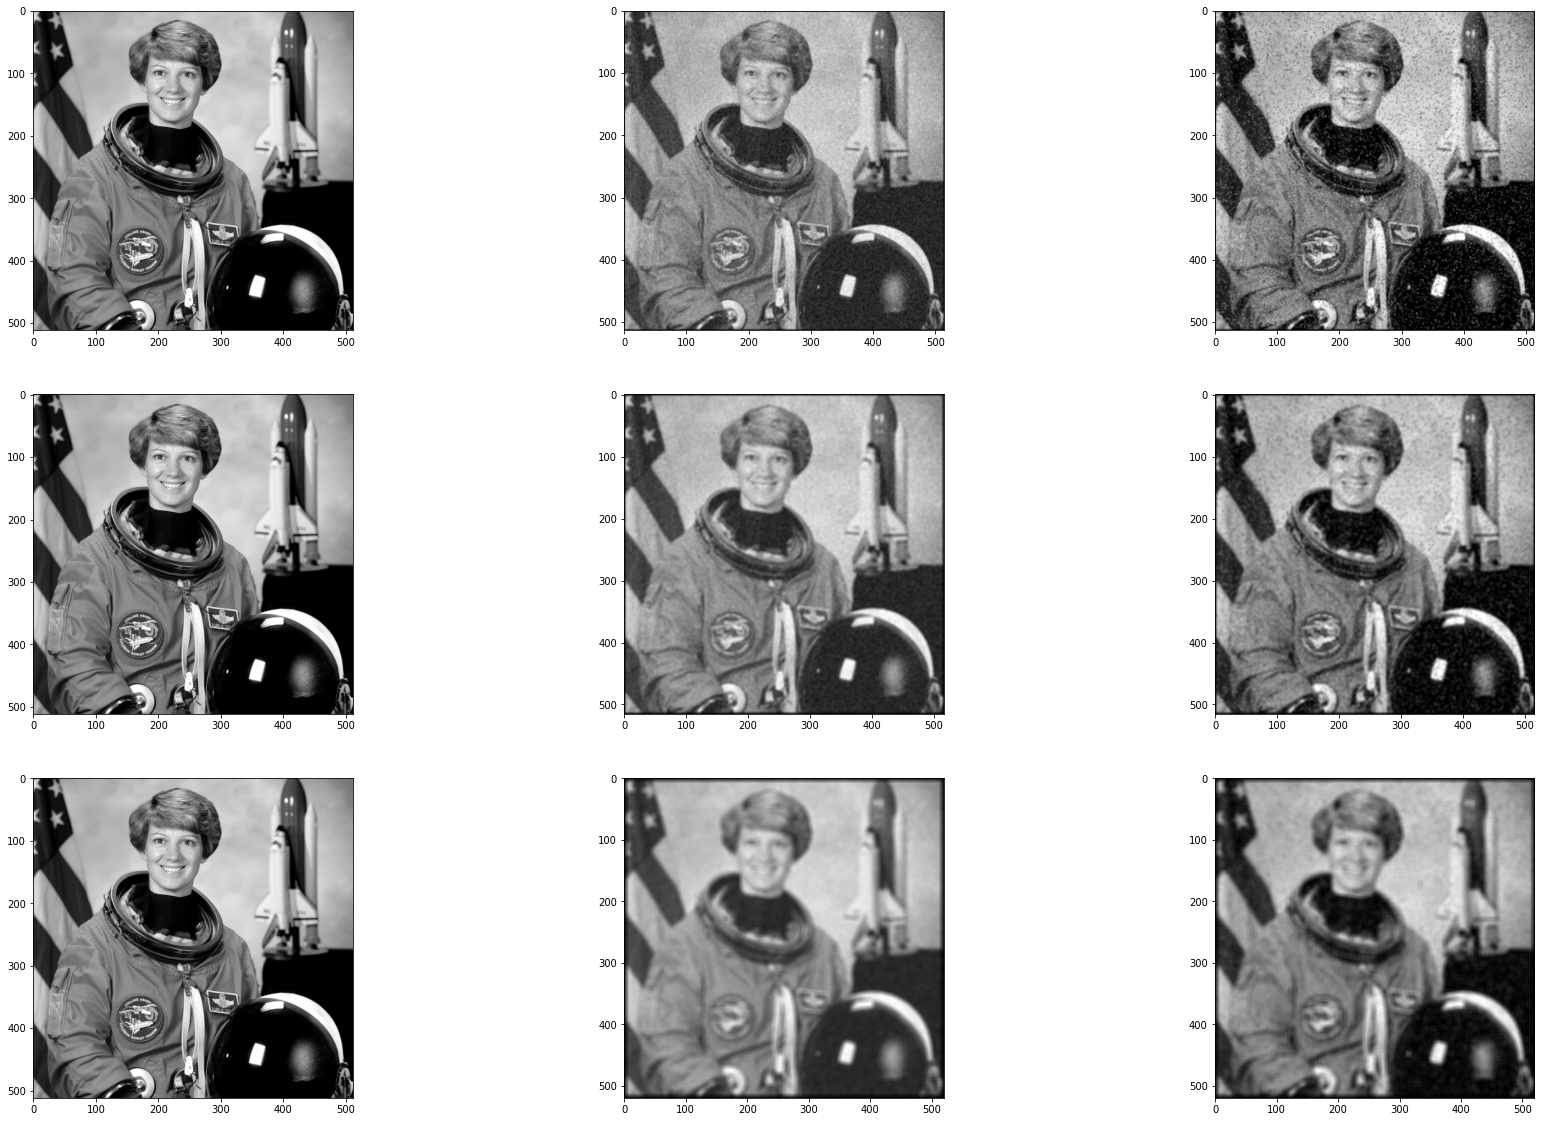

In [11]:
conv_image1 = convolution(gaussian_img, mean_3_x_3, 1, padding=True)
conv_image2 = convolution(salt_pepper_img, mean_3_x_3, 1, padding=True)
conv_image3 = convolution(gaussian_img, mean_5_x_5, 1, padding=True)
conv_image4 = convolution(salt_pepper_img, mean_5_x_5, 1, padding=True)
conv_image5 = convolution(gaussian_img, mean_9_x_9, 1, padding=True)
conv_image6 = convolution(salt_pepper_img, mean_9_x_9, 1, padding=True)

figure, axarr = plt.subplots(3,3, figsize=(30, 20))
axarr[(0, 0)].imshow(image, cmap='gray')
axarr[(0 ,1)].imshow(conv_image1, cmap='gray')
axarr[(0, 2)].imshow(conv_image2, cmap='gray')
axarr[(1, 0)].imshow(image, cmap='gray')
axarr[(1, 1)].imshow(conv_image3, cmap='gray')
axarr[(1, 2)].imshow(conv_image4, cmap='gray')
axarr[(2, 0)].imshow(image, cmap='gray')
axarr[(2, 1)].imshow(conv_image5, cmap='gray')
axarr[(2, 2)].imshow(conv_image6, cmap='gray')

A figura acima mostra a imagem original, a imagem com ruído gaussiano e a imagem com ruído sal e pimenta respectivamente, suavizadas com um kernel de média de diferentes tamanhos espaciais. Como era de se esperar, o filtro 9x9 acaba gerando muita perda de nitidez na imagem e o filtro 3x3 é pequeno demais para eliminar completamente os ruídos, sendo o 5x5 a melhor escolha nessa situação, alcanando maior sucesso no *trade-off* de agregar os ruídos à imagem enquanto mantém os detalhes finos.

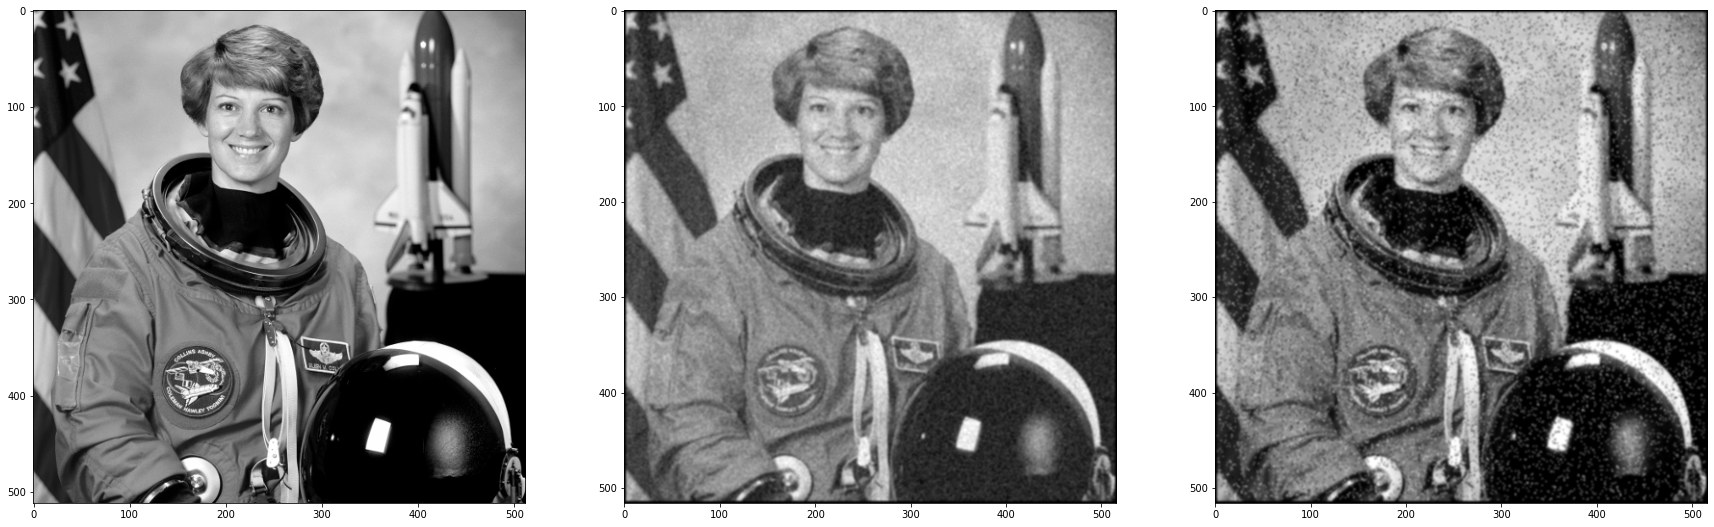

In [12]:
gaussian = np.array([[1,4,6,4,1], [4,16,24,16,4], 
                     [6,24, 36, 24, 6], [4,16,24,16,4], [1,4,6,4,1]])

conv_gaussian1 = convolution(gaussian_img, gaussian, 1, padding=True)
conv_gaussian2 = convolution(salt_pepper_img, gaussian, 1, padding=True)
figure, axarr = plt.subplots(1,3, figsize=(30, 20))
axarr[0].imshow(image, cmap='gray')
axarr[1].imshow(conv_gaussian1, cmap='gray')
axarr[2].imshow(conv_gaussian2, cmap='gray')

O filtro Gaussiano também não alcançou bons resultados na remoção de ruído da imagem em questão, ficando similar a um filtro de média 3x3.

Para aplicação do filtro da mediana ao invés da multiplicação matricial com um kernel, como visto nos outros métodos, optou-se por criar uma função chamada *apply_median_kernel* responsável por pegar o valor da mediana de cada área do kernel.

In [13]:
def apply_median_kernel(kernel_area):
    flatten_kernel = kernel_area.flatten()
    sorted_kernel = sorted(flatten_kernel)
    median_index = len(flatten_kernel) // 2
    return sorted_kernel[median_index]

Os kernels da mediana foram definidos com os valores zerados, pois embora a multiplicação matricial não seja aplicada, é necessário que a área do filtro seja definida para ser aplicada a imagem.

In [14]:
median_3_x_3 = np.full((3,3), 0)
median_5_x_5 = np.full((5,5), 0)
median_9_x_9 = np.full((9,9), 0)
median_3_x_3

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

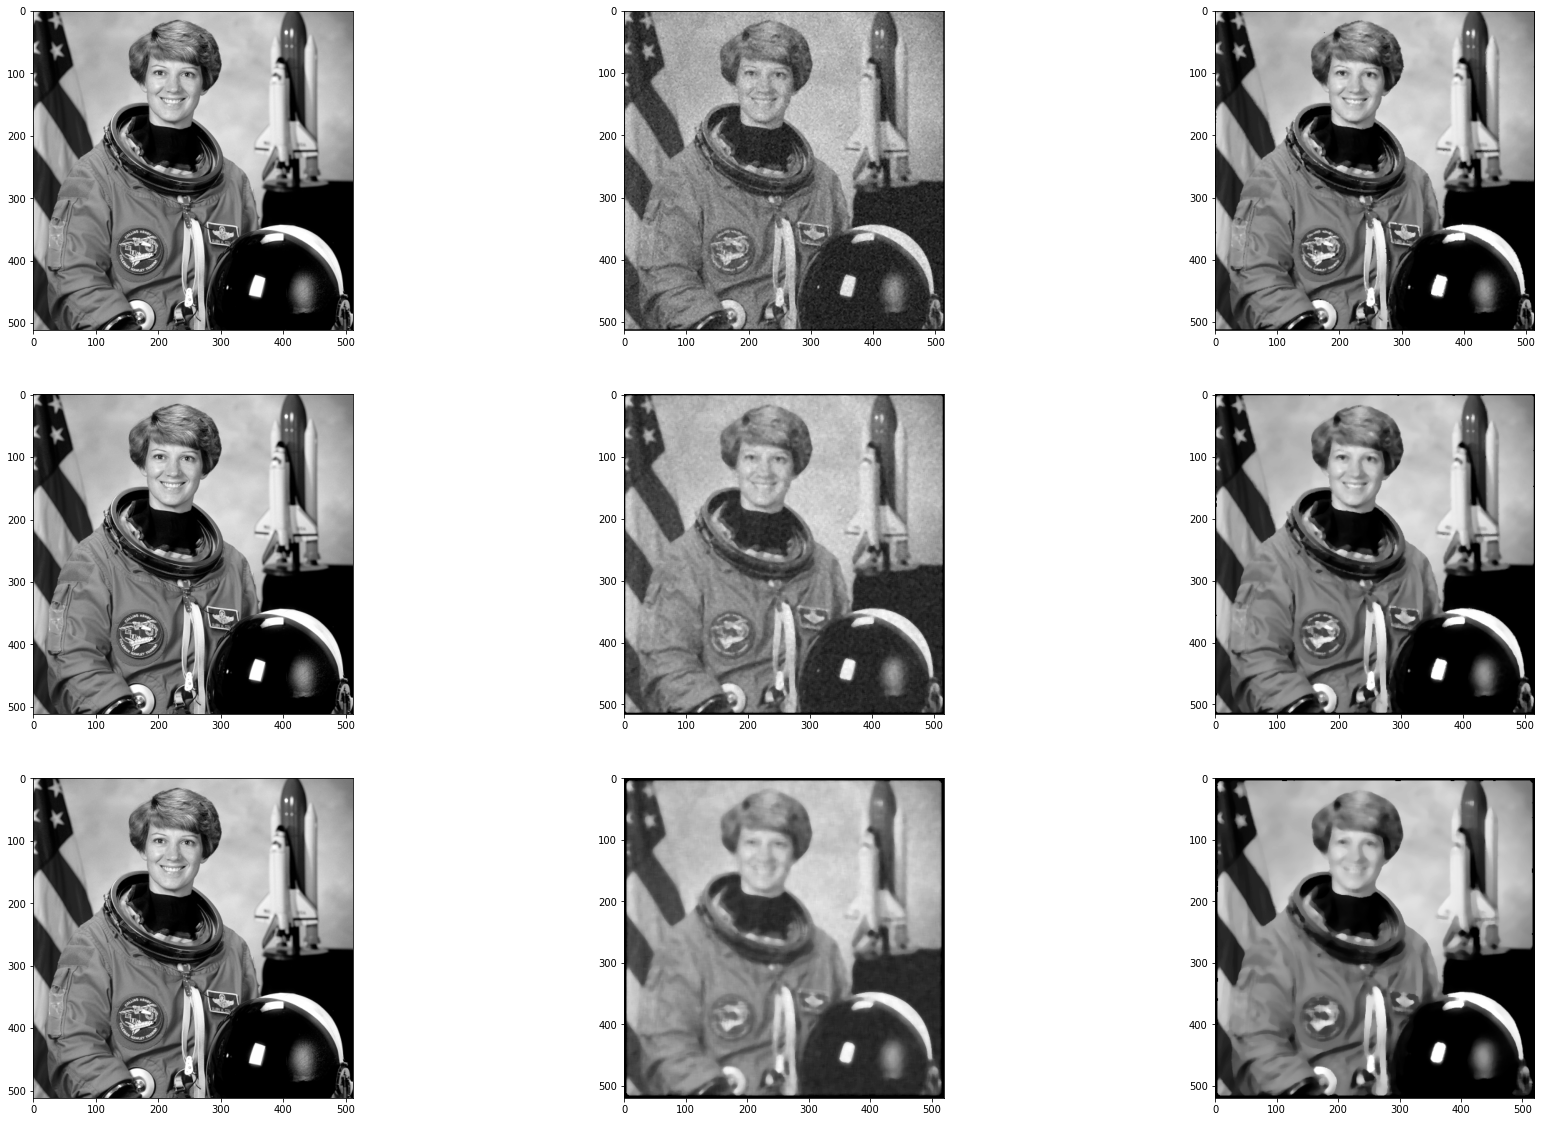

In [15]:
conv_image1 = convolution(gaussian_img, median_3_x_3, 1, apply_median_kernel, True)
conv_image2 = convolution(salt_pepper_img, median_3_x_3, 1, apply_median_kernel, True)
conv_image3 = convolution(gaussian_img, median_5_x_5, 1, apply_median_kernel, True)
conv_image4 = convolution(salt_pepper_img, median_5_x_5, 1, apply_median_kernel, True)
conv_image5 = convolution(gaussian_img, median_9_x_9, 1, apply_median_kernel, True)
conv_image6 = convolution(salt_pepper_img, median_9_x_9, 1, apply_median_kernel, True)

figure, axarr = plt.subplots(3,3, figsize=(30, 20))
axarr[(0, 0)].imshow(image, cmap='gray')
axarr[(0 ,1)].imshow(conv_image1, cmap='gray')
axarr[(0, 2)].imshow(conv_image2, cmap='gray')
axarr[(1, 0)].imshow(image, cmap='gray')
axarr[(1, 1)].imshow(conv_image3, cmap='gray')
axarr[(1, 2)].imshow(conv_image4, cmap='gray')
axarr[(2, 0)].imshow(image, cmap='gray')
axarr[(2, 1)].imshow(conv_image5, cmap='gray')
axarr[(2, 2)].imshow(conv_image6, cmap='gray')

É interessante notar que o filtro da mediana também não é muito eficaz na remoção do ruído Gaussiano, uma vez que esse se apresenta por toda a imagem, fazendo muito mais o papel de uma agregador do ruído a imagem. Todavia, a remoção do ruído sal e pimenta e perfeitamente realizado mesmo com um filtro de mediana 3x3, uma vez que os valores de outlier do sal e da pimenta nunca caem no 50° percentil. 

## Transformada de Fourrier
A transformada de Fourrier foi implementada utilizando a função do SKImage